In [1]:
from pycaret.regression import *
import pandas as pd
import matplotlib.pyplot as plt
from functions import accuracy
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
df_raw = pd.read_csv('kunak_filled.csv', parse_dates=[0], index_col=0)
df=df_raw.asfreq('H')

In [3]:
week = 24*7
step = 0
date_to = week*4
errors = {}
training_to_prediction = []

In [4]:
while (step+date_to)<=(df.shape[0]):
    
    sample = df[-date_to-step:].copy()
    
    
    target = 'NO2 (ppb)'
    steps = int(sample.shape[0]*0.25)
    
    train = sample[:-steps]
    test = sample[-steps:]
    
    numeric_features = df.columns.drop(target).to_list()
    
    s = setup(data=train, test_data=test, target=target, fold_strategy='timeseries',
          numeric_features=numeric_features,
          fold=3, silent=True, session_id=123, verbose=0)
    
    model = create_model('rf', verbose=False)
    
    prediction_steps = 24*3
    predictions = predict_model(model, data=test[-prediction_steps:], verbose=False)
    
    errors_list = [mean_absolute_error(predictions[target][-prediction_steps:], predictions.Label[-prediction_steps:]),
               mean_squared_error(predictions[target][-prediction_steps:], predictions.Label[-prediction_steps:]),
              accuracy(predictions[target][-prediction_steps:], predictions.Label[-prediction_steps:])['mape'],
              r2_score(predictions[target][-prediction_steps:], predictions.Label[-prediction_steps:])]
    
    print(test.shape[0]/sample.shape[0])
  
        
    errors[str(df.index[-date_to-step].date())] = errors_list
    step += 2*week

0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


In [5]:
errors_df = pd.DataFrame(errors).T
errors_df.columns=['MAE', 'MSE', 'MAPE', 'R2']
errors_df.index = pd.to_datetime(errors_df.index)
errors_df

,MAE,MSE,MAPE,R2
2022-08-08,1.411480,4.774364,0.021,0.980461
2022-07-25,1.551108,6.034516,0.022,0.975304
2022-07-11,3.535364,36.465569,0.051,0.850764
2022-06-27,1.329031,5.048349,0.018,0.979340
2022-06-13,1.522522,6.230883,0.021,0.974500
2022-05-30,1.063814,2.917251,0.015,0.988061
2022-05-16,1.081329,3.057449,0.015,0.987487
2022-05-02,1.057125,2.966587,0.015,0.987859
2022-04-18,0.939253,2.460194,0.013,0.989932


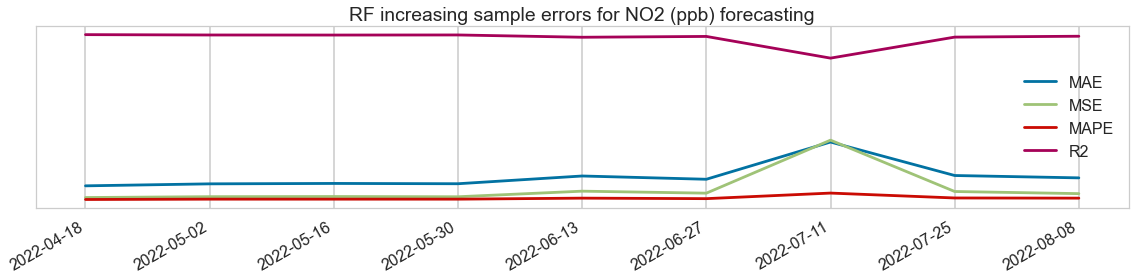

In [7]:
plt.style.use('seaborn-poster')
errors_df_scaled = errors_df.copy()
errors_df_scaled.iloc[:,1] = errors_df_scaled['MSE']/10
errors_df_scaled.iloc[:,2] = errors_df_scaled['MAPE']*10
errors_df_scaled.iloc[:,3] = errors_df_scaled['R2']*10
errors_df_scaled.plot(figsize=(16,4), x_compat=True)
plt.yticks([])
plt.xticks(errors_df.index)
plt.legend(loc='center right')
plt.title(f"RF increasing sample errors for {target} forecasting")
plt.tight_layout()
plt.savefig(f"Plots/rf/{target}_rolling_back.png")
plt.show()